# Crée une calculatrice avec un algorithme de Deep Learning

## 1. Importations

In [19]:
import numpy as np 
import matplotlib.pyplot as plt # pip install matplotlib, sert à tracer les courbes
import torch 
from torch import nn # sert à créer des modèles de réseaux de neurones
from torch.utils.data import DataLoader, TensorDataset # sert à créer des datasets
from tqdm import tqdm # pip install tqdm, sert à afficher une barre de progression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # sert à calculer les métriques
import random
from torchsummary import summary # pip install torchsummary, sert à afficher le nombre de paramètres du modèle

## 2. Configuration du matériel

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if torch.cuda.is_available():
    print("Le GPU est utilisé")
else:
    print("Le GPU n'est PAS utilisé, le CPU est utilisé")

#? paramètre de matplotlib
# plt.rcParams.update({
#     "figure.facecolor": "#1E1E1E",  # Couleur de fond de la figure
#     "axes.facecolor": "#1E1E1E",    # Couleur de fond des axes
#     "axes.edgecolor": "white",      # Couleur des bords des axes
#     "axes.titlecolor": "white",     # Couleur du titre des axes
#     "axes.labelcolor": "white",     # Couleur des étiquettes des axes
#     "xtick.color": "white",         # Couleur des graduations des abscisses
#     "ytick.color": "white",         # Couleur des graduations des ordonnées
#     "text.color": "white",          # Couleur du texte
# })

Le GPU est utilisé


## 3. Fonction de création du jeu de données

In [21]:
def create_calculator_dataset(num_samples, min_value, max_value, operation):
    X = np.random.randint(min_value, max_value+1, (num_samples, 2))
    if operation == 'add':
        y = X[:, 0] + X[:, 1]
    elif operation == 'multiply':
        y = X[:, 0] * X[:, 1]
    else:
        raise ValueError("Operation not recognized. Use 'add' or 'multiply'")
    X = X / max_value
    if operation == 'add':
        y = y / (2 * max_value)
    elif operation == 'multiply':
        y = y / (max_value * max_value)
    return X, y

## 4. Architecture du réseau

In [22]:
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=40, output_size=1, num_hidden_layers=4, activation_fn=nn.ReLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.layers.extend([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers-1)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation_fn = activation_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = self.output_layer(x)
        return x


## 5. Fonctions d'entraînement et de préparation

In [23]:
# Fonction de création du DataLoader
from sklearn.model_selection import train_test_split

def create_calculator_dataloaders(num_samples=1000, min_value=0, max_value=10, operation='add', batch_size=64, val_split=0.2):
    X, y = create_calculator_dataset(num_samples, min_value, max_value, operation)
    
    # Division en ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)
    
    # Conversion en tenseurs et déplacement vers le périphérique
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    # Création des DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader


# Fonction pour obtenir l'optimiseur
def get_optimizer(model, optimizer_name="adam", lr=0.001):
    if optimizer_name.lower() == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr)
    raise ValueError("Optimizer not recognized. Use 'adam' or 'sgd'.")

# Fonction d'entraînement du modèle
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer_name="sgd", lr=0.1):
    model.to(device)
    optimizer = get_optimizer(model, optimizer_name, lr)
    loss_fn = nn.MSELoss() # fonction de perte, vous pouvez aussi essayez nn.L1Loss() qui est la MAE
    train_loss_history = []
    val_loss_history = []
    
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Phase d'entraînement
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs.view(-1), y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_loss_history.append(epoch_train_loss)
        
        # Phase de validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                outputs = model(X_batch)
                loss = loss_fn(outputs.view(-1), y_batch)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_dataloader)
        val_loss_history.append(epoch_val_loss)
        
    return train_loss_history, val_loss_history


## 6. Entraînement et visualisation des résultats

Training Progress: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


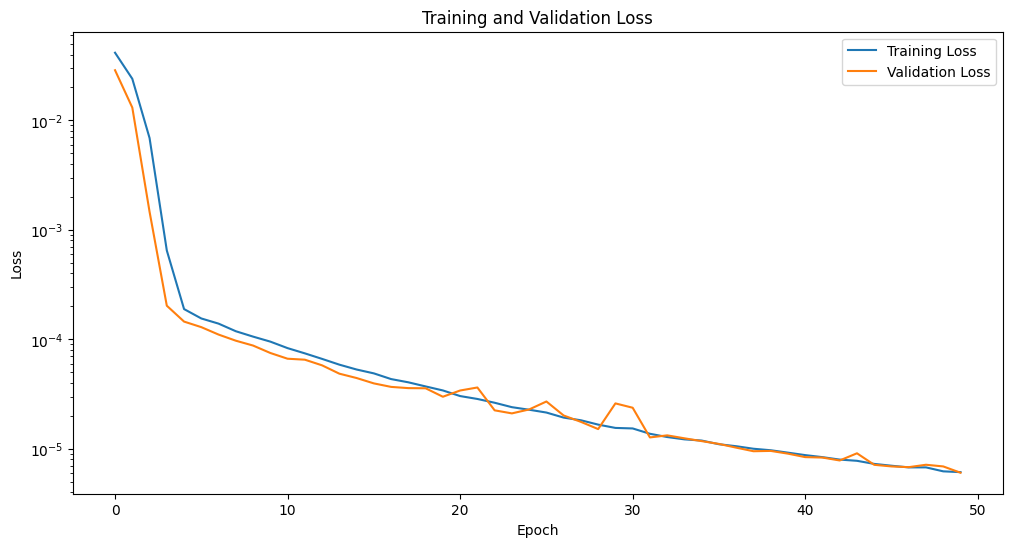

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 16]             272
              ReLU-4                [-1, 1, 16]               0
            Linear-5                [-1, 1, 16]             272
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 1]              17
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [24]:
# Paramètres pour la création du jeu de données
num_samples = 2500          # Nombre d'échantillons à générer. Ex: 5000, 10000, 15000, etc.
min_value = 0                # Valeur minimale pour la génération de nombres. Ex: 0, 10, -10, etc.
max_value = 100              # Valeur maximale pour la génération de nombres. Ex: 100, 200, 500, etc.
operation = 'add'            # Opération à effectuer. Options : 'add' ou 'multiply'.
batch_size = 32              # Taille des lots pour l'entraînement. Ex: 32, 64, 128, etc.
learning_rate = 0.1          # Taux d'apprentissage. "adam", 0.001 ou "sgd", 0.1
optimizer = "sgd"            # Optimiseur. "adam" ou "sgd"

# Paramètres pour le modèle MLP
input_size = 2               # Taille de l'entrée. Pour notre cas, c'est toujours 2.
hidden_size = 16             # Nombre de neurones dans les couches cachées. Ex: 10, 20, 50, etc.
output_size = 1              # Taille de la sortie. Pour notre cas, c'est toujours 1.
num_hidden_layers = 3        # Nombre de couches cachées. Ex: 1, 2, 3, 4, etc.
activation_fn = nn.ReLU()    # Fonction d'activation. Ex: nn.ReLU(), nn.Sigmoid() nn.Tanh() et nn.LeakyReLU().

# Paramètres pour l'entraînement
epochs = 50                  # Nombre d'époques pour l'entraînement. Ex: 5, 10, 20, etc.


#? Initialisation du modèle
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_hidden_layers=num_hidden_layers, activation_fn=activation_fn).to(device)

#? Création des DataLoaders d'entraînement et de validation
train_dataloader, val_dataloader = create_calculator_dataloaders(
    num_samples=num_samples, min_value=min_value, max_value=max_value,
    operation=operation, batch_size=batch_size, val_split=0.2
)

#? Entraînement du modèle
train_loss_history, val_loss_history = train_model(
    model, train_dataloader, val_dataloader, epochs=epochs,
    optimizer_name=optimizer, lr=learning_rate
)

# Affichage des courbes de perte
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')  # Appliquer une échelle logarithmique
plt.legend()
plt.show()

summary(model, input_size=(1, input_size))

# 8. Test set sur des données inconnues

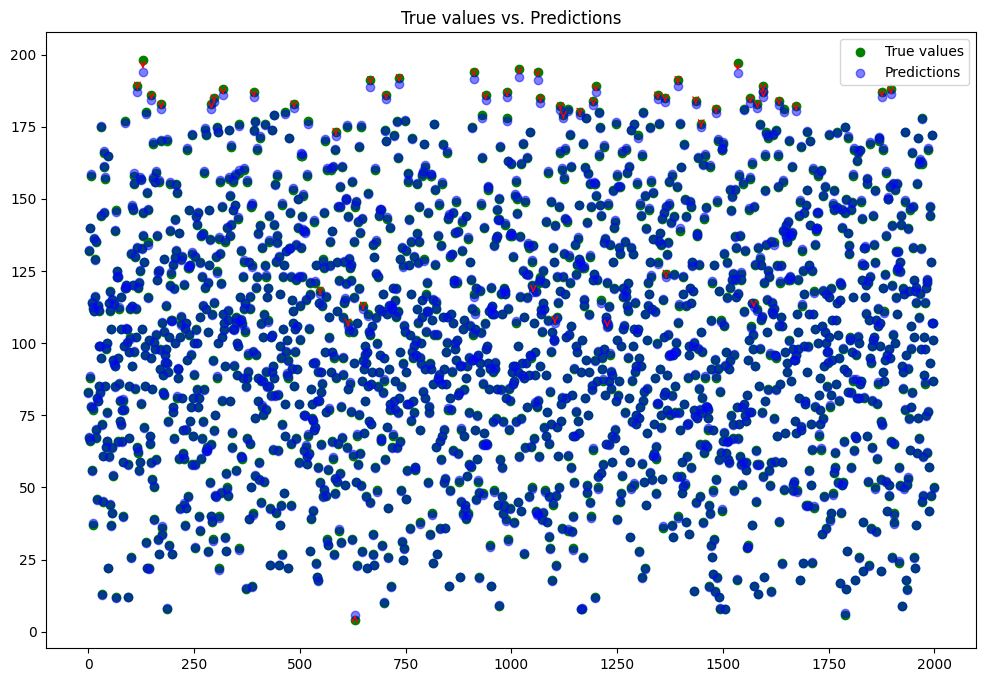

Mean Squared Error (MSE): 0.1943
Mean Absolute Error (MAE): 0.3187
R-squared (R2): 0.9999


In [25]:
# Fonction de test du modèle
def test_model(model, num_samples, min_value, max_value, operation):
    X_test, y_test = create_calculator_dataset(num_samples, min_value, max_value, operation)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_denormalized = (y_pred * (2 * max_value)).squeeze().cpu().numpy()
    return y_pred_denormalized, y_test * (2 * max_value)

# Fonction de tracé des prédictions
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(y_true)), y_true, color='green', label="True values")
    plt.scatter(range(len(y_pred)), y_pred, color='blue', alpha=0.5, label="Predictions")
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        difference = pred-true
        if abs(difference) > 1:
            plt.annotate("", xy=(i, pred), xytext=(i, true), arrowprops=dict(arrowstyle="->", color='red'))
    plt.title("True values vs. Predictions")
    plt.legend()
    plt.show()
    

#? Test et visualisation des prédictions
num_samples = 2000

y_pred, y_true = test_model(model, num_samples, min_value, max_value, operation)
plot_predictions(y_true, y_pred)

#? Évaluation des performances à l'aide de différentes métriques
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# 9. Prédictions sur des données écrire à la main

In [26]:
def predict_sum(model, num1, num2, max_value=100):
    # Normaliser les entrées
    X_input = torch.tensor([[num1/max_value, num2/max_value]], dtype=torch.float32).to(device)
    
    # Effectuer une inférence
    with torch.no_grad():
        prediction = model(X_input)
    
    # Dénormiliser la prédiction
    predicted_sum = prediction * (2 * max_value)  # Pour l'addition
    return predicted_sum.item()

# Test de la fonction
result = predict_sum(model, 50, 50)
print(f"La somme prédite de 50 et 50 est : {result:.2f}")
print(f"La somme réelle de 50 et 50 si on arrondit au entier est : {np.round(result):.0f}")

print("\n")

# Test de la fonction
result = predict_sum(model, 6, 6)
print(f"La somme prédite de 6 et 6 est : {result:.2f}")
print(f"La somme réelle de 6 et 6 si on arrondit au entier est : {np.round(result):.0f}")

La somme prédite de 50 et 50 est : 100.02
La somme réelle de 50 et 50 si on arrondit au entier est : 100


La somme prédite de 6 et 6 est : 11.89
La somme réelle de 6 et 6 si on arrondit au entier est : 12
